https://www.gdeltproject.org/data/lookups/FIPS.country.txt

In [6]:
country_code = 'YM'

In [5]:
from google.cloud import bigquery
from google.oauth2 import service_account

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
credentials = service_account.Credentials.from_service_account_file(
    '../keys/projecttest-318006-34f075e5bede.json', scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id)

query = f"""
SELECT SQLDATE, EventCode
FROM `gdelt-bq.gdeltv2.events` 
WHERE ActionGeo_CountryCode = @country
ORDER BY SQLDATE DESC
LIMIT 200000
"""

job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ScalarQueryParameter("country", "STRING", country_code)
    ]
)
query_job = client.query(query, job_config=job_config) 

In [17]:
country_df = query_job.to_dataframe()

humanitarian_crisis_events = ['0233', '0243', '0333', '0343', '0243', '073', '074', '0833', '0861', '0863',
                              '092', '094', '103', '1033', '1043', '1122', '1124', '1233', '137', '138', 
                              '1382', '1383', '1384', '1385', '1413', '1423', '1451', '1452', '1453', '1454', 
                              '175', '18', '180', '181', '182', '1821', '1822', '1823', '183', '1831', '1832', 
                              '1833', '184']

country_df['IsHumanitarianCrisis'] = country_df.EventCode.isin(humanitarian_crisis_events)

country_df.SQLDATE = pd.to_datetime(country_df.SQLDATE, format='%Y%m%d', errors='ignore')
country_df = country_df.set_index('SQLDATE')
country_df_grouped = country_df['IsHumanitarianCrisis'].groupby(pd.Grouper(freq='d')).agg(['sum','count','mean'])

country_df_grouped.columns = ['HumanitarianCrisisEvents', 'TotalEvents', 'HumanitarianCrisisProportions']
humanitarian_crisis_ts = country_df_grouped.HumanitarianCrisisProportions

In [51]:
lookup_df = pd.read_csv('../data/country_code_lookup.csv')
country_name = lookup_df[lookup_df['Country Code'] == country_code].Country.values[0]

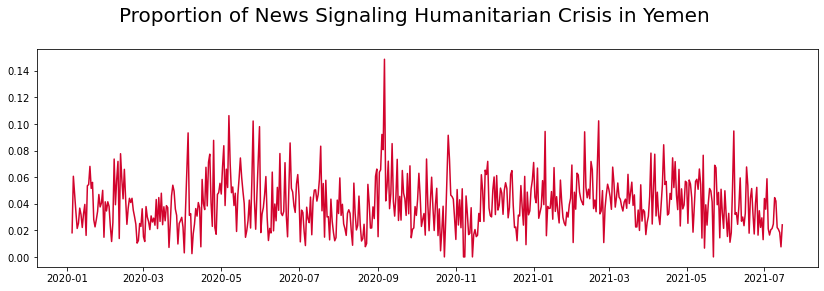

In [58]:
plt.figure(figsize=(14, 4))
plt.figtext(.5,.9,f'Proportion of News Signaling Humanitarian Crisis in {country_name}\n', fontsize=20, ha='center')
plt.plot(humanitarian_crisis_ts, color='#D2042D') ;

Results of Dickey-Fullter Test:
Test Statistic          -7.862065e+00
p-value                  5.251979e-12
# Lags Used              4.000000e+00
# of Obs Used            5.530000e+02
Critiical Values: 1%    -3.442230e+00
Critiical Values: 5%    -2.866781e+00
Critiical Values: 10%   -2.569561e+00
dtype: float64


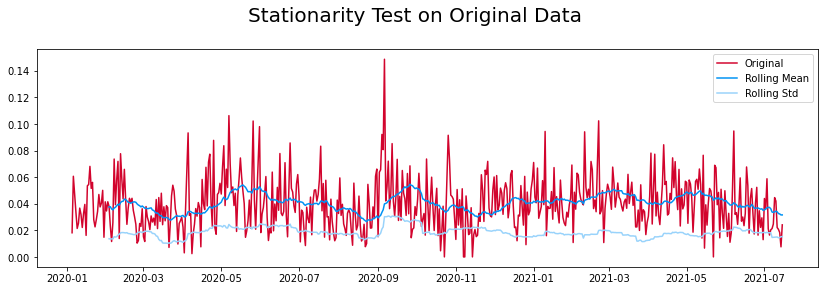

In [97]:
from statsmodels.tsa.stattools import adfuller

def stationarity_test(ts, window=30, title='Stationarity Test'):
    print('Results of Dickey-Fullter Test:')
    dftest = adfuller(ts, autolag = 'AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', '# of Obs Used'])
    for k, v in dftest[4].items():
        dfoutput[f'Critiical Values: {k}'] = v
    
    print(dfoutput)
        
    rollmean = ts.rolling(window=window).mean()
    rollstd = ts.rolling(window=window).std()
    
    plt.figure(figsize=(14, 4))
    original = plt.plot(ts, color = '#D2042D', label = 'Original')
    mean = plt.plot(rollmean, color = '#0092F4', label = 'Rolling Mean')
    std = plt.plot(rollstd, color = '#99d3fb', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.figtext(.5,.9,f'{title}\n', fontsize=20, ha='center')


stationarity_test(humanitarian_crisis_ts, title='Stationarity Test on Original Data')

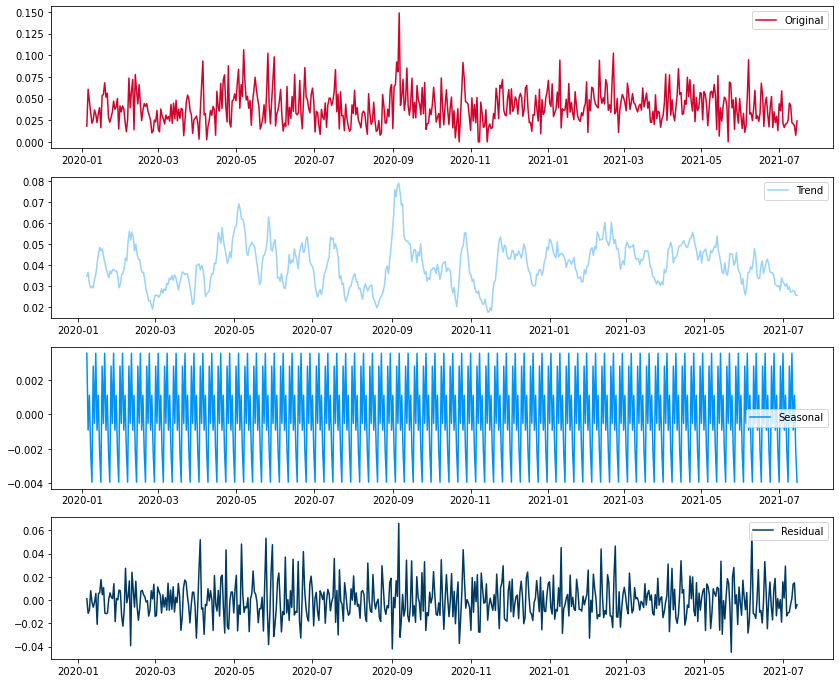

In [87]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(humanitarian_crisis_ts)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(14,12))
plt.subplot(411)
plt.plot(humanitarian_crisis_ts, label = 'Original', color = '#D2042D')
plt.legend()
plt.subplot(412)
plt.plot(trend, label = 'Trend', color = '#99d3fb')
plt.legend()
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal', color = '#0092F4')
plt.legend()
plt.subplot(414)
plt.plot(residual, label = 'Residual', color = '#003a62')
plt.legend(loc='upper right')

Results of Dickey-Fullter Test:
Test Statistic          -1.076089e+01
p-value                  2.522556e-19
# Lags Used              1.800000e+01
# of Obs Used            5.330000e+02
Critiical Values: 1%    -3.442678e+00
Critiical Values: 5%    -2.866978e+00
Critiical Values: 10%   -2.569666e+00
dtype: float64


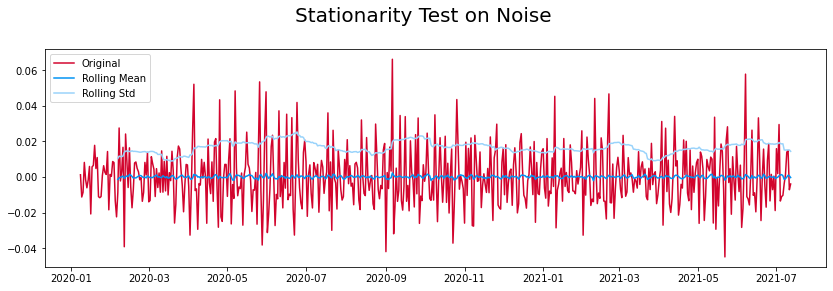

In [98]:
stationarity_test(residual.dropna(), title='Stationarity Test on Noise')

In [95]:
from pmdarima import auto_arima